# PARTIE 3 : Transfer learning

Dans cette partie nous utilisons DistilBERT pour notre problématique. Il s'agit d'une version allégée du célèbre algorithme BERT de Google.

BERT signifie Bidirectional Encoder Representations from Transformers --> C'est un modèle qui comprend le sens des mots dans un texte **en tenant compte du contexte**.

Ce modèle a été pré-entraîné sur de grands ensembles de donneés textuelles (11000 livres et l'ensemble de Wikipedia en anglais soit un total d'environ 3,3 milliard de mots).

DistilBERT convient particulièrement pour la détection de spam et pour notre cas où nous n'avons qu'un petit jeu de données (5500 messages).

## Import des données

In [1]:
import pandas as pd
df = pd.read_csv('messages.csv')

In [2]:
df.head()

,label,message
0,0,jurong point crazy available bugis n great wor...
1,0,ok lar joke wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun early hor u c
4,0,nah think usf live


In [ ]:
df.shape

(5555, 2)

## Preprocessings

### Distinguer les variables

In [3]:
X = df['message'].values
y = df['label'].values

### Séparation des données en un train set et test set

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Chargement du tokeniser et du modèle DistilBERT

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

### Fonction pour convertir les messages en embeddings DistilBERT

In [ ]:
!pip install transformers scikit-learn torch

In [7]:
import torch
import numpy as np

def encode_texts_batch(texts, tokenizer, model, max_len=64, batch_size=16):
    """
    Cette fonction encode une liste de textes en embeddings DistilBERT
    """
    # Tokeniser les textes avec padding/truncation :
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        encodings = tokenizer(
            list(batch_texts),
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt"
        )

        # Obtenir les embeddings en désactivant le calcul des gradients :
        with torch.no_grad():
            outputs = model(
                input_ids=encodings['input_ids'],
                attention_mask=encodings['attention_mask']
            )

            # Extraire les embeddings [CLS] (premier token)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_embeddings)

    return np.vstack(all_embeddings)

### Application de la fonction

In [ ]:
print("Encodage des messages d'entraînement...")
train_embeddings = encode_texts_batch(X_train, tokenizer, model, max_len=64, batch_size=16)

print("Encodage des messages de test...")
test_embeddings = encode_texts_batch(X_test, tokenizer, model, max_len=64, batch_size=16)

# Temps d'entraînement : 6 min 32 s

Encodage des messages d'entraînement...
Encodage des messages de test...


## Modèle de régression logistique

Nous entraînons un modèle de classification sur les messages qui ont été encodés par DistilBERT.

In [9]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(train_embeddings, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Prédictions et évaluation

### Récupération de toutes les métriques

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss

def evaluate_model(model, X, y):
    '''
    Cette fonction retourne sous forme de dictionnaire les métriques :
    accuracy, precision, recall, F1 score
    '''
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    loss = log_loss(y, y_pred)

    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1,
                          'loss': loss}

    return model_results_dict

In [11]:
model_results = evaluate_model(classifier, test_embeddings, y_test)
model_results

{'accuracy': 0.990999099909991,
 'precision': 0.9735099337748344,
 'recall': 0.9607843137254902,
 'f1-score': 0.9671052631578947,
 'loss': 0.324425323034358}

### Matrice de confusion

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(test_embeddings)

# Nous transformons les probabilités en prédictions spam (1) ou non-spam (0) :
y_pred_binary = np.round(y_pred).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Matrice de confusion :")
print(conf_matrix)

Matrice de confusion :
[[954   4]
 [  6 147]]


Text(16.25, 0.5, 'Actual')

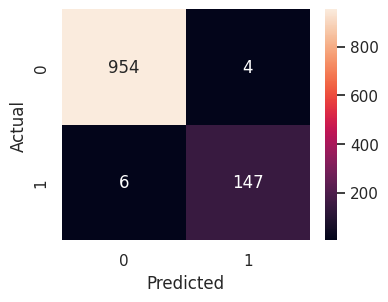

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(4, 3)}, style='white')
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### Rapport de classification

In [14]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy : 0.990999099909991
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       958
           1       0.97      0.96      0.97       153

    accuracy                           0.99      1111
   macro avg       0.98      0.98      0.98      1111
weighted avg       0.99      0.99      0.99      1111



## Conclusion

DistilBERT nous a permis de créer un modèle de prédiction avec de très bons résultats.

Le modèle est capable de prédire correctement 97% des messages spam (Precision).

Sur l'ensemble des vrais spams, il arrive à en prédire 96% (Recall).

Le F1 score est de 0,97. Il est meilleur qu'avec les modèles de deep learning utilisés précédemment (0,92).